<table align="left" style="border-style: hidden" class="table"> <tr><td class="col-md-2"><img style="float" src="http://prob140.org/assets/icon256.png" alt="Prob140 Logo" style="width: 120px;"/></td><td><div align="left"><h3 style="margin-top: 0;">Probability for Data Science</h3><h4 style="margin-top: 20px;">UC Berkeley, Fall 2021</h4><p>Ani Adhikari</p>CC BY-NC 4.0</div></td></tr></table><!-- not in pdf -->

In [1]:
from prob140 import *
from datascience import *
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.style.use('fivethirtyeight')

In [2]:
def split_unit_interval(cdf_table):
    plt.figure(figsize=(1,4))
    values = cdf_table.column(cdf_table.num_columns - 1)
    cum = list(np.cumsum(values))
    cur_axes = plt.gca()
    cur_axes.axes.get_xaxis().set_visible(False)
    plt.yticks([0] + cum)
    plt.ylim(-0.1, 1.1)
    plt.plot([0,0], [0,1], color="darkblue", lw=3)
    plt.xlim(-0.12, 1)
    plt.scatter([0]*(len(cum) + 1),
                [0] + cum, s=55, color="k")

# Lab 3: Success Runs and Other Patterns #

Consider a sequence of i.i.d. Bernoulli $(p)$ trials. We will use the standard image of tossing a coin that lands heads with chance $p$. So we will denote success by $\rm H$ and failure by $\rm T$.

For $n > 1$, the first *run of $n$ successes* is the earliest trial at which $n$ consecutive successes have been observed. For example, if the sequence of tosses starts out with $\rm THHHTHHHH$, then the first run of two successes happens at Trial 3, the first run of three successes happens at Trial 4, and the first run of four successes happens at Trial 9.

Success runs carry information about $p$. For example, if you see long success runs early in the sequence of trials, you might want to infer that $p$ is large.

In this lab, you will study the random number of trials needed to get a success run of a specified length. You will then extend your calculations to the number of trials till you get patterns of successes and failures (for example, $\rm HT$ instead of $\rm HH$), and then to patterns of letters chosen randomly from the alphabet.

At the end of the lab you will know the expected time a monkey will take to type $\rm ABRACADABRA$ by hitting letters uniformly at random on a keyboard, and, by extension, the expected time it will take to type out the complete works of Shakespeare.

Fortunately, [monkeys know better](https://www.wired.com/2003/05/monkeys-dont-write-shakespeare/) than to engage in such things. But in the human world, success runs have uses in information theory, reliability and quality control, genetics, and other areas. Also, expected waiting times till patterns appear have beautiful patterns of their own - they are well worth studying.

What you will learn in this lab:

- A simple formula for expected waiting time till a run of $n$ successes
- How to simulate the distribution of the waiting time till a run of $n$ successes
- Approximations to the distribution of the waiting time
- Extensions of the expectation formula to patterns of successes and failures
- How to know the expected waiting time till any pattern, just by looking at the pattern

## Instructions
Your labs have two components: a written portion and a portion that also involves code. Written work should be completed on paper, and coding questions should be done in the notebook. You are welcome to LaTeX your answers to the written portions, but staff will not be able to assist you with LaTeX related issues. It is your responsibility to ensure that both components of the lab are submitted completely and properly to Gradescope. Refer to the bottom of the notebook for submission instructions.

## Preliminary: Simulating Discrete Random Variables ##
Data scientists often simulate data under specified models of randomness. In this and future labs, you will use Python to simulate random variables that have a given distribution. 

The general call is `stats.distribution_name.rvs(parameters, size=n)`. This evaluates to an array of $n$ observed values of i.i.d. random variables of the specified distribution. The acronym `rvs` stands for "random variates".

To see how this works, start by using Python to simulate a single Bernoulli ($\frac{1}{6}$) random variable. In other words, ask Python to roll a die and tell you whether or not it landed six. Run the cell a few times.

In [3]:
stats.bernoulli.rvs(1/6, size=1)

array([0])

If you are curious about how Python generates the 0 or 1, here is a visualization of what it does. Later in the course, you will study this method in far greater generality.

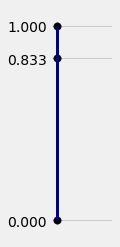

In [10]:
six_on_one_roll = Table().values([0, 1]).probabilities([5/6, 1/6])
split_unit_interval(six_on_one_roll)

The unit interval $[0, 1]$ has been split into two parts, one of length 5/6 (approximately 0.833) and the other of the remaining length 1/6.

The Python function for generating one Bernoulli $(1/6)$ random variable essentially throws a dart uniformly on the unit interval. If the dart lands in the interval (0, 5/6), it returns 0. If the dart lands in (5/6, 1), it returns 1. (If you are wondering what happens if the dart lands exactly at 5/6, or 0, or 1, for now please just accept that the chance of that is 0. We will discuss this issue later in the course.)

Since the dart is thrown uniformly, the chance that it lands in the lower interval is 5/6 of the total length 1, which is 5/6. So the chance that the function returns 0 is 5/6, which is exactly what it should be. It follows that the chance that the function returns 1 is 1/6.

There is nothing special about the Bernoulli distribution as far as this process is concerned. Every discrete distribution can be simulated in an analogous way. The graph below shows how Python simulates the number of heads in two tosses of a coin.

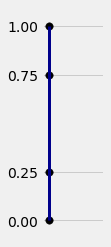

In [5]:
heads_in_two_tosses = Table().values([0, 1, 2]).probabilities([1/4, 1/2, 1/4])
split_unit_interval(heads_in_two_tosses)

The process:

- Throw a dart uniformly on the unit interval.
    - If the dart lands in the lowest interval, return 0.
    - If the dart lands in the middle interval, return 1.
    - If the dart lands in the highest interval, return 2.
    
In a future lab, you will study the process further and develop a general method of simulating random variables with specified distributions.

Now that you understand roughly what Python is doing, focus on the code. Read each cell below carefully before you run it. Also, run each cell several times to see how the output changes.

In [7]:
# One Bernoulli (1/6) variable
# The output of stats.distribution_name.rvs is an array

stats.bernoulli.rvs(1/6, size = 1)

array([1])

Compare this with:

In [11]:
# One Bernoulli (1/6) variable
# Use .item() to access the variable as a value that you can work with directly

stats.bernoulli.rvs(1/6, size = 1).item(0)

0

Simulating sixes in 10 rolls of a die:

In [12]:
# 10 i.i.d. Bernoulli (1/6) variables

stats.bernoulli.rvs(1/6, size = 10)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

SciPy defines the geometric $(p)$ random variable in the same way as in our class - the number of trials till the first success in i.i.d. Bernoulli $(p)$ trials. Thus the possible values of a geometric random variable are 1, 2, 3, $\ldots$.

In [14]:
# Waiting time till the first six in rolls of a die

stats.geom.rvs(1/6, size = 1)

array([1])

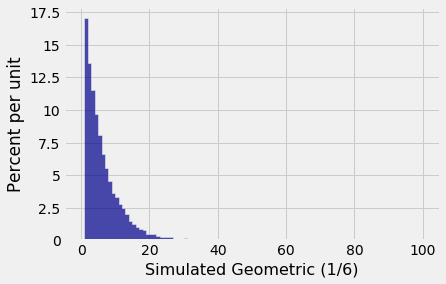

In [15]:
# Empirical histogram of 10,000 i.i.d. repetitions of
# counting the number of rolls till the first six

wait_till_six = stats.geom.rvs(1/6, size = 10000)
Table().with_column('Simulated Geometric (1/6)', wait_till_six).hist(
    bins = np.arange(101))

This is an empirical approximation of the geometric $(\frac{1}{6})$ probability histogram below.

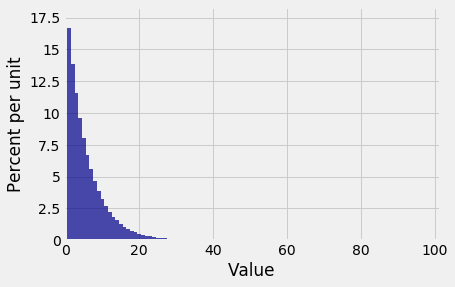

In [16]:
# Probability histogram of geometric (1/6) random variable

k = np.arange(1, 101)
probs = stats.geom.pmf(k, 1/6)
geom_dist = Table().values(k).probabilities(probs)
Plot(geom_dist)

As you know, if a random variable $X$ has the geometric $(p)$ distribution, the probability mass function of $X$ is given by

$$
P(X = k) ~ = ~ q^{k-1}p, ~~ k \ge 1
$$

Here $q = 1-p$ is standard notation that we will be using throughout the lab.

For each $k \ge 2$, $P(X = k) = qP(X = k-1)$. You can see that the height of each bar of the probability histogram is $\frac{5}{6}$ the height of the previous bar.

## Part 1: Expected Time Till a Success Run ##
[Section 9.3](http://prob140.org/textbook/content/Chapter_09/03_Expected_Waiting_Times.html) of the textbook is **required reading** before you go further. The probabilistic techniques you need for this lab are versions of those in the section. Skipping the reading will not save time because you will most likely just take longer to answer the questions below.

In a sequence of i.i.d. Bernoulli $(p)$ trials, let $W_{\text{pattern}}$ be the number of trials till $\text{pattern}$ appears. We call this the *waiting time* till $\text{pattern}$ appears.

Thus $W_\text{H}$ is the waiting time till $\text{H}$ appears, $W_{\text{HH}}$ is the waiting time till a success run of length 2, and so on. This is the same notation as in Section 9.3.

### 1a) [ON PAPER] Expectations of $W_{\rm H}$ and $W_{\rm HH}$ ###

Use the results of Section 9.3 to fill in the blanks below with math expressions involving **only** positive terms of the form $1/p^k$ for $k \ge 1$. Show any algebra that you use.

(1) $E(W_\text{H}) ~ = ~ \underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$

(2) $E(W_{\text{HH}}) ~ = ~ \underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$

#solution

(1) $\frac{1}{p}$

(2) $\frac{1+p}{p^2} = \frac{1}{p^2} + \frac{1}{p}$

### 1b) [ON PAPER] Expectation of $W_{\text{HHH}}$ ###

Find $E(W_{\text{HHH}})$ by conditioning on the trial after $W_{\text{HH}}$, as follows.

- Notice that to get to $W_{\text{HHH}}$ you first have to get to $W_{\text{HH}}$, whose expectation you already know.
- Let $x = E(W_{\text{HHH}})$. This is what you are trying to find.
- Think about what happens on the trial that follows $W_{\text{HH}}$, and develop an equation for $x$. Refer to Answer 2 of the example *Waiting for HH* in Section 9.3.
- Solve the equation.

As in **1a**, your answer should involve only positive terms of the form $1/p^k$ for $k \ge 1$. Show any algebra that you use.

#solution

$x ~ = ~ E(W_{\text{HH}}) + 1 + (0 \cdot p) + (x \cdot q)$

So $px ~ = ~ E(W_{\text{HH}}) + 1 ~ = ~ \frac{1}{p^2} + \frac{1}{p} + 1$

So $x ~ = ~ \frac{1}{p^3} + \frac{1}{p^2} + \frac{1}{p}$

### 1c) [ON PAPER] Expected Waiting Time Till a Success Run of Length $n$ ###

By an abuse of notation, let $W_{\text{H},n}$ be the waiting time till $n$ consecutive successes appear. Thus for example $W_{\rm{H},7}$ is notation for $W_{\rm{HHHHHHH}}$. It's more compact and it spares you having to count the number of successes in the run.

(1) Use your answers to **1a** and **1b** to guess a formula for $E(W_{{\rm{H}},n})$ for $n \ge 1$.

(2) Use induction to prove your guess. Adapt the method used in **1b**.

#staff

It will be easier for students to use ... than sigma notation. That's fine.

#solution

(1) Guess $E(W_{{\rm H},n}) ~ = ~ \sum_{k=1}^n \frac{1}{p^k} ~ = ~ \frac{1}{p^n} + \frac{1}{p^{n-1}} + \cdots + \frac{1}{p}$. By **1a** and **1b**, the formula is correct for $n = 1, 2, 3$.

(2) Assume that the formula is correct for $n$. Let $x = E(W_{{\rm H}, n+1})$. By conditioning on the trial after $W_{{\rm H},n}$:

$x ~ = ~ E(W_{{\rm H},n}) + 1 + (0 \cdot  p) + (x + q)$, and so $px = E(W_{{\rm H},n}) + 1$.

So $\displaystyle x ~ = ~ \frac{1}{p} \sum_{k=1}^n \frac{1}{p^k} + \frac{1}{p} ~ = ~ \sum_{k=2}^{n+1} \frac{1}{p^k} + \frac{1}{p} ~ = ~ \sum_{k=1}^{n+1} \frac{1}{p^k}$ which is the guess for $n+1$.

### 1d) Numerical Values ###

Define a function `ev_W_run` that takes $p$ and $n$ as arguments and returns $E(W_{{\rm H},n})$. Just replace the ellipsis by an expression. Do not add any other lines of code.

In [ ]:
#student
def ev_W_run(p, n):
    return ...

In [24]:
#solution
def ev_W_run(p, n):
    return sum(1 / p ** np.arange(1, n+1))

What should `ev_W_run(1/6, 1)` evaluate to? Run the cell below to check that your function works in this case.

In [ ]:
#student
ev_W_run(1/6, 1)

In [25]:
#solution
ev_W_run(1/6, 1)

6.0

What should `ev_W_run(0.5, 3)` evaluate to? Run the cell below to confirm.

In [ ]:
#student
ev_W_run(0.5, 3)

In [26]:
#solution
ev_W_run(0.5, 3)

14.0

Now use `ev_W_run` to find the expectation of each of the following random variables.

(1) number of tosses of a fair coin till 10 consecutive heads appear 

(2) number of rolls of a die till six consecutive sixes appear

(3) number of times a random number generator is run till 000 appears, if the generator draws at random with replacement from the 10 digits 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9

(4) number of days till a robot types $\text{ZZZZZ}$ if the robot types at the rate of 10 letters per second (without breaks) and chooses letters at random with replacement from the 26 upper case letters of the English alphabet

In [ ]:
#student
# Expected number of:

# (1) fair coin tosses till 10 consecutive heads
ans_1 = ...

# (2) rolls of a die till 6 consecutive sixes
ans_2 = ...

# (3) runs of a random number generator till 000
ans_3 = ...

# (4) days till ZZZZZ by robot typist
ans_4 = ...

ans_1, ans_2, ans_3, ans_4

In [27]:
#solution
# Expected number of:

# (1) fair coin tosses till 10 consecutive heads
ans_1 = ev_W_run(1/2, 10)

# (2) rolls of a die till 6 consecutive sixes
ans_2 = ev_W_run(1/6, 6)

# (3) runs of a random number generator till 000
ans_3 = ev_W_run(1/10, 3)

# (4) days till ZZZZZ by robot typist
ans_4 = ev_W_run(1/26, 5) / (10 * 60 * 60 * 24)

ans_1, ans_2, ans_3, ans_4

(2046.0, 55986.000000000015, 1109.9999999999998, 14.301655092592588)

#newpage

## Part 2: Distribution of the Time Till a Success Run ##
For general positive integer $n$, the distribution of $W_{{\rm H},n}$ has been known for a long time. The derivation requires some math, and the formula has connections with the Fibonacci numbers, as you can see [here](https://www.fq.math.ca/Scanned/23-2/philippou.pdf) for example. 

Though the math isn't easy, you can simulate $W_{{\rm H},n}$ quite easily. That is what you will do in this part of the lab. The simulations will give you insight about the distribution using almost no math at all.

To simulate a value of $W_{{\rm H},n}$, you clearly need an iteration: 

- Toss once and see if the pattern appears;
- if it doesn't, toss again and repeat ...
- until the pattern appears.

The number of iterations is therefore random. The process stops when a condition is satisfied ("the pattern appears"), not at some previously specified number of iterations as in a `for` loop.

In Python, `while` loops are used in such cases. If you have seen `while` in another class, you can go directly to **2a** below. If not, go through the preliminary example here.

As explained in Professor DeNero's [Composing Programs](http://composingprograms.com/pages/15-control.html):

A while clause contains a header expression followed by a suite:

```
while < expression >: 
    < suite >
```
To execute a while clause:

- Evaluate the header's expression.
- If it is a true value, execute the suite, then return to step 1."

`expression` will be a Boolean. If it is `True`, the "suite" of code — a sequence of lines of code — will be executed. After the "suite" of code finishes executing, `expression` will be evaluated again, and the process will continue until `expression` evaluates to `False`. Then the process will end.

It is *really bad news* if `expression` is never false, because then the process will continue forever. In our examples, `expression` will be `False` if a coin shows a specified face or if a specified pattern appears. These events are certain to happen at some point, so our loops will end.

Suppose we have a coin that lands heads with chance $p = 0.2$. In the example below, we will get Python to toss the coin until it lands heads, and display the results of all the tosses. The details:

- Starting point: an empty collection array called `failures`
- The `while` header expression: Toss the 0.2 coin and see if it is a 0
- If the coin shows 0:
    - The `suite`: append 0 to `failures`
    - Return to the `while` header expression
- If the coin shows 1, stop

When the process stops, the array `failures` will contain one 0 for every toss before the final one, but it will *not* contain 1 for the final toss that stopped the process. So we will append 1 to `failures` and display the result. In this way we will have simulated $W_{\rm H}$ for $p = 0.2$.

In [ ]:
failures = make_array()  

while stats.bernoulli.rvs(0.2, size=1).item(0) == 0:  # toss; while you get 0
    failures = np.append(failures, 0)                 # append 0 to failures

# This while loop stops when a toss lands 1.
# Show all the failures and the success that stopped the process.

np.append(failures, 1)

### 2a) Simulating One Value of $W_{{\rm H},n}$ ###
Complete the cell below to define a function `run` that takes $p$ and $n$ as arguments and returns one simulated value of $W_{{\rm H},n}$.

As you toss, you will be keeping track of how many times you have tossed and also the number of consecutive heads that include the toss just completed.

For example, suppose you are waiting for the pattern ${\rm HHH}$.

- If the first three tosses are ${\rm HTH}$, then you will successively note:
    - tosses = 1, consecutive heads = 1
    - tosses = 2, consecutive heads = 0
    - tosses = 3, consecutive heads = 1
    - and you will continue to toss.
- If the first six tosses are ${\rm THTHHH}$, then you will successively note:
    - tosses = 1, consecutive heads = 0
    - tosses = 2, consecutive heads = 1
    - tosses = 3, consecutive heads = 0
    - tosses = 4, consecutive heads = 1
    - tosses = 5, consecutive heads = 2
    - tosses = 6, consecutive heads = 3
    - and you will stop tossing.

In [ ]:
#student
def run(p, n):
    """Returns one simulated value of W_H,n
    in i.i.d. Bernoulli (p) trials"""
    
    tosses = 0                   # Number of tosses
    in_a_row = 0                 # Number of consecutive heads observed
    
    while in_a_row < n:          # While fewer than n consecutive heads
        tosses = ...             # update tosses
        if ...:                           
            in_a_row = ...                # update in_a_row
        else:
            in_a_row = ...                # reset in_a_row
    
    return tosses

In [29]:
#solution
def run(p, n):
    """Returns one simulated value of W_H,n
    in i.i.d. Bernoulli (p) trials"""
    
    tosses = 0                   # Number of tosses
    in_a_row = 0                 # Number of consecutive heads observed
    
    while in_a_row < n:          # While fewer than n consecutive heads
        tosses = tosses + 1      # update tosses
        if stats.bernoulli.rvs(p, size=1).item(0) == 1:   
            in_a_row = in_a_row + 1       # update in_a_row
        else:
            in_a_row = 0                  # reset in_a_row
    
    return tosses

For a crude check of your function, think about whether `run(0.9, 1)` should evaluate to a large number of tosses or a small number, and then see what your function returns. Run the cell a few times.

In [ ]:
#student
run(0.9, 1)

In [30]:
#solution
run(0.9, 1)

1

Now run the next cell to see if the function behaves differently.

In [ ]:
#student
run(0.1, 1)

In [31]:
#solution
run(0.1, 1)

8

### 2b) Repeated Simulation ###
For a more thorough check, it will help to use the function several times and then check the properties of the collection of simulated values.

So use the function `run` to define a new function `simulate_run` that takes as its arguments $p$, $n$, and a positive integer `repetitions`, and returns an array consisting of length equal to `repetitions`, each of whose entries is a simulated value of $W_{{\rm H},n}$. Use as many lines of code as you need.

In [ ]:
#student
def simulate_run(p, n, repetitions):
    """Returns an array of length equal to repetitions,
    whose entries are independent simulated values of W_H,n
    in i.i.d. Bernoulli (p) trials"""
    ...
    return ...

In [32]:
#solution
def simulate_run(p, n, repetitions):
    """Returns an array of length equal to repetitions,
    whose entries are independent simulated values of W_H,n
    in i.i.d. Bernoulli (p) trials"""
    results = make_array()
    for i in np.arange(repetitions):
        results = np.append(results, run(p, n))
    return results

What should the value of `np.mean(simulate_run(0.5, 3, 10000))` be, roughly? Look at **1d** for a reminder. Then run the cell below to confirm. The simulation might take a while, and the approximation might be a bit off. That's OK.

In [ ]:
#student
np.mean(simulate_run(0.5, 3, 10000))

In [33]:
#solution
np.mean(simulate_run(0.5, 3, 10000))

13.9744

### 2c) Empirical Distribution of $W_{{\rm HH}}$ When $p = 0.5$ ###
Create an array `sim_W_HH` consisting of 10,000 independent simulated values of $W_{{\rm HH}}$ for a fair coin.

In [ ]:
#student
sim_W_HH = ...

In [34]:
#solution
sim_W_HH = simulate_run(0.5, 2, 10000)

Run the cell below to display an empirical histogram of $W_{{\rm HH}}$ for a fair coin.

In [ ]:
#student
Table().with_column('Simulated W_HH', sim_W_HH).hist(bins = np.arange(1.5, 40.5))

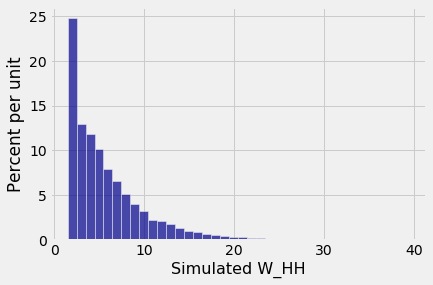

In [35]:
#solution
Table().with_column('Simulated W_HH', sim_W_HH).hist(bins = np.arange(1.5, 40.5))

That's an unusual shape! As a check, run the cell below and compare the results:

In [ ]:
#student
ev_W_run(0.5, 2), np.mean(sim_W_HH)

In [36]:
#solution
ev_W_run(0.5, 2), np.mean(sim_W_HH)

(6.0, 5.967)

Calculate the probabilities corresponding to the first three bars, as listed below. Remember that the histogram is an empirical approximation to the exact probability histogram, so what you calculate might not be exactly what you see. But is should be close. Also remember that the coin is fair.

For each of the following, find the exact probability and state whether it is consistent with the approximations in the histogram.

(1) $P({\rm W_{HH}} = 2)$

(2) $P({\rm W_{HH}} = 3)$

(3) $P({\rm W_{HH}} = 4)$

#student

**Your answer here.**

#solution

(1) Event = $\rm HH$ on first two tosses. So chance = 1/4; consistent.

(2) Event = $\rm THH$ on first three tosses. So chance = 1/8; consistent.

(3) Event = $\rm TTHH$ or $\rm HTHH$ on the first four tosses. So chance = 2(1/16) = 1/8, consistent.

### 2d) Empirical Distribution of $W_{{\rm H},5}$ When $p = 0.5$ ###

Create an array `sim_W_H5` consisting of 10,000 independent simulated values of $W_{{\rm H},5}$. The simulation takes a while.

In [ ]:
#student
...

In [37]:
#solution
sim_W_H5 = simulate_run(0.5, 5, 10000)

Draw the empirical histogram of the values in `sim_W_H5`. Use `hist` with the option `bins = np.arange(5, 501, 10)`.

In [ ]:
#student
...
plt.ylim(0, 0.0175); # ignore; forces the vertical scale to go up to 1.75 %/unit

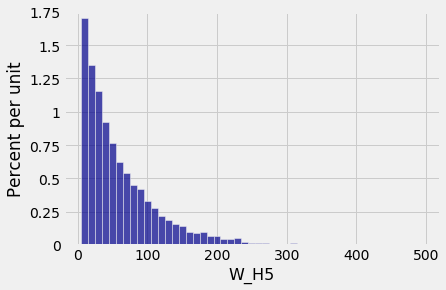

In [38]:
#solution
Table().with_column('W_H5', sim_W_H5).hist(bins = np.arange(5, 501, 10))
plt.ylim(0, 0.0175); # ignore; forces the vertical scale to go up to 1.75 %/unit

To check that your simulated values make sense, run the cell below and compare the two resulting values.

In [ ]:
#student
ev_W_run(0.5, 5), np.mean(sim_W_H5)

In [39]:
#solution
ev_W_run(0.5, 5), np.mean(sim_W_H5)

(62.0, 61.3676)

### 2e) Approximate Distribution of $W_{{\rm H},5}$ ###

The histogram in **2d** has a recognizable shape. Fill in the blanks below to figure out a straightforward approximation to the probability distribution of $W_{{\rm H},5}$.

(1) Fill in the blank with a number: $E(W_{{\rm H},5}) = \underline{~~~~~~~~~~~~~~~~~~}$.

(2) Fill in the blank with a range of values. If the range is infinite, it's fine to use "..." or any reasonable description.

The possible values of $W_{{\rm H},5}$ are $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$.

(3) Fill in the blank with one of the names binomial, Poisson, and geometric: 

The shape of the empirical distribution of $W_{{\rm H},5}$ resembles the shape of a $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$ distribution, but the possible values are different.

(4) Fill in the first blank with a number, the second with the name you chose in (3), and the third with the appropriate numerical parameter or parameters. Carefully go through your answers to (1)-(3) before you fill in these blanks.

The distribution of $W_{{\rm H},5}$ is pretty close to the distribution of $X + \underline{~~~~~~~~~~~~~}$ where $X$ has the $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$ distribution with parameter (or parameters) $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$.

#student

**Your answer here.**

(1) ...

(2) ...

(3) ...

(4) Blank 1: ...; Blank 2: ...; Blank 3: ...


#solution

(1) 62

(2) 5, 6, 7, ...

(3) geometric

(4) 4, geometric, 1/58

Now complete the cell to plot the probability histogram of the approximating distribution in (4). We have started you off with an array of possible values but you might have to adjust the possible values later in the cell.

In [ ]:
#student
k = np.arange(1, 1001)
approx_probs = stats...pmf(k, ...)
approx_dist = Table().values(...).probabilities(approx_probs)

# Ignore; Forces hist to use the same scale as the empirical histogram 
approx_dist.hist(bin_column='Value', bins=np.arange(5, 501, 10))
plt.ylim(0, 0.0175);

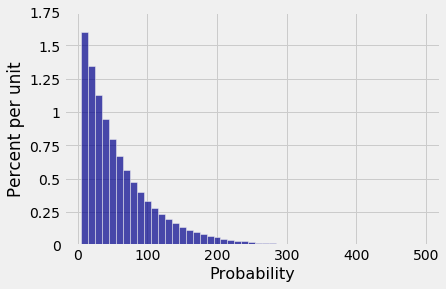

In [40]:
#solution
k = np.arange(1, 1001)
approx_probs = stats.geom.pmf(k, 1/58)
approx_dist = Table().values(k+4).probabilities(approx_probs)

# Ignore; Forces hist to use the same scale as the empirical histogram 
approx_dist.hist(bin_column='Value', bins=np.arange(5, 501, 10))
plt.ylim(0, 0.0175);

Here is your empirical distribution of $W_{{\rm H},5}$ again, for ease of reference.

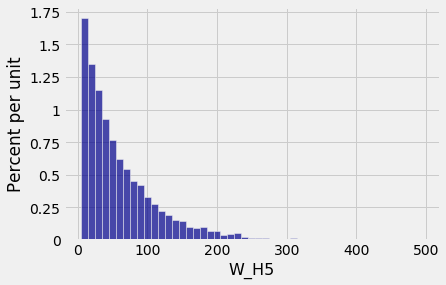

In [41]:
Table().with_column('W_H5', sim_W_H5).hist(bins = np.arange(5, 501, 10))

Your approximation should be pretty good though of course it will be a bit off. What you have discovered is also true for larger values of $n$, that is, for waiting times till longer success runs. 

As above, let $p = 0.5$. In the cell below, find an approximate value of $P(W_{{\rm H},5} > 100)$ as an arithmetic expression using just elementary operations. You should be able to calculate it on a hand calculator if you didn't have this notebook. **Do not** use the distributions calculated above or `stats`, `special` or other modules.

In [ ]:
#student
...

In [13]:
#solution
(57/58) ** 96

0.18832100471449834

Now check if your answer is consistent with your simulation, by writing an expression that evaluates to the proportion of entries in `sim_W_H5` that are greater than 100.

#staff

There are many ways of calculating this proportion. Any correct expression is fine.

In [ ]:
#student
...

In [42]:
#solution
np.count_nonzero(sim_W_H5 > 100) / 10000

0.1856

#newpage

## Part 3: Other Patterns ##
In this part of the lab, the patterns aren't just runs of successes. Instead, they include failures.

**Note:** Markov Chains are often used to find these expectations. But that method ends up with pretty much the same set of equations that you will derive here, and the equations are cumbersome to solve when the patterns are long. Part 4 of the lab takes care of that problem.

### 3a) Decomposing $W_{{\rm HT}}$ ###

Suppose the first few trials are ${\rm TTTTHHHTHHT}$. Identify the value of $W_{{\rm HT}}$ in this case, and then fill in the blank below:

To get to $W_{{\rm HT}}$, I waited till the first $\rm H$ and then I waited till the first $\underline{~~~~~~~~~~~}$.

#student

**Your answer here.**

#solution

$\rm T$

The cell below generates 50 i.i.d. Bernoulli $(0.4)$ variables, so $\rm H$ is 1 and $\rm T$ is 0 as usual. Run the cell and look for the first occurrence of the pattern 10. Is your observation above still true?

Run the cell several times, and check every time whether your observation holds. It is possible, though not likely, that you don't see 10 in the 50 trials. That's fine. Just run the cell again.

In [25]:
stats.bernoulli.rvs(0.4, size=50)

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1])

Fill in the blanks:

$W_{\rm HT} ~ = ~ W_{\rm H} + V$ where $V$ is independent of $W_{\rm H}$ and has the $\underline{~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~}$ distribution.

#student

**Your answer here.**

#solution

Geometric ($q$)

Find $E(W_{\rm HT})$ in terms of $p$ and $q$.

#student

**Your answer here.**

#solution

1/p + 1/q

### 3b) Comparing $W_{\rm HH}$ and $W_{\rm HT}$ When $p = 0.5$ ###

Use your answers in **2d** and **3a** to find $E(W_{\rm HH})$ and $E(W_{\rm HT})$ in the case $p = 0.5$.

#student

**Your answer here.**

#solution

From 2d, $E(W_{\rm HH}) = 6$. By 3a, $E(W_{\rm HT}) = 2 + 2 = 4$.

The two answers aren't equal, even though the coin is fair and the patterns have the same length. 

To see why, start by completing the cell below. Use 10,000 simulated values and remember that $p = 0.5$.

#staff

The independence of $W_{\rm H}$ and $V$ wasn't needed for $E(W_{\rm HT}) = E(W_{\rm H}) + E(V)$. But note the use of the independence in the simulation below. We are generating two independent sets of 10,000 geometric (1/2) variables and then adding.

In [ ]:
#student
# Fair coin: Empirical histogram of W_HT based on 10,000 simulated values

sim_W_HT = ...

Table().with_column('Simulated W_HT', sim_W_HT).hist(bins = np.arange(1.5, 40.5))

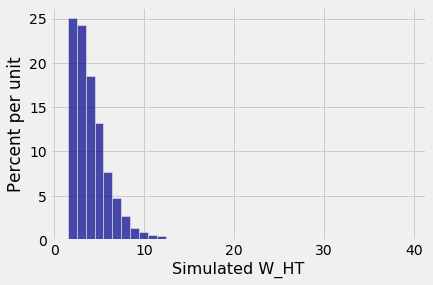

In [43]:
#solution
# Fair coin: Empirical histogram of W_HT based on 10,000 simulated values

sim_W_HT = stats.geom.rvs(0.5, size = 10000) + stats.geom.rvs(0.5, size = 10000)

Table().with_column('Simulated W_HT', sim_W_HT).hist(bins = np.arange(1.5, 40.5))

Now compare with the empirical distribution of $W_{\rm HH}$ below. You drew a histogram of that distribution in **2c**; the code is repeated below for ease of reference.

Also use the subsequent code cell to find the means of the two sets of simualted values and check that they are consistent with your answers at the start of this exercise.

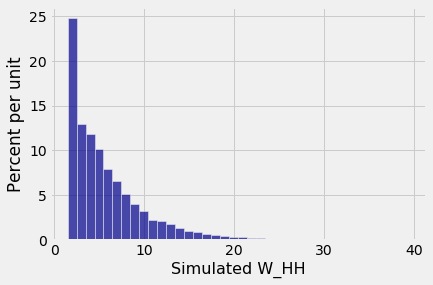

In [44]:
# Fair coin: Empirical histogram of W_HH based on 10,000 simulated values

Table().with_column('Simulated W_HH', sim_W_HH).hist(bins = np.arange(1.5, 40.5))

In [ ]:
#student
np.mean(sim_W_HH), np.mean(sim_W_HT)

In [45]:
#solution
np.mean(sim_W_HH), np.mean(sim_W_HT)

(5.967, 4.0275)

The histograms clearly show why the two expectations are not equal. But you can also see the reason with minimal calculation and no graphs, as follows.

Fill in the blanks with patterns:

To compare $W_{\rm HH}$ and $W_{\rm HT}$ in tosses of a fair coin,
- in both cases it takes the same expected time to first get to $W_{\rm H}$;
- in both cases, the pattern appears on the next toss with the same chance 0.5;
- in both cases, the pattern fails to appear on the next toss with the same chance 0.5, and then:
    - to get to $W_{\rm HH}$ you have to wait till $\underline{~~~~~~~~~~~~~~~~~}$ appears in the subsequent tosses, whereas
    - to get to $W_{\rm HT}$ you have to wait till $\underline{~~~~~~~~~~~~~~~~~}$ appears in the subsequent tosses.

#student

**Your answer here.**

#solution

HH, T

### 3c) [ON PAPER] Expectation of $W_{\rm HTH}$

Find $E(W_{\rm HTH})$ by conditioning on $W_{\rm HT}$. By now you're an expert on how to do this. Follow the process in **1b** and **1c**.

#solution

Let $x = E(W_{\rm HTH})$. Then $x = E(W_{\rm HT}) + 1 + (0 \cdot p) + (x \cdot q)$, and so $px = \frac{1}{p} + \frac{1}{q} + 1$.

So $x = \frac{1}{p^2} + \frac{1}{pq} + \frac{1}{p}$.

#newpage

## Part 4: A Pattern in the Answers ##
For several different patterns of successes and failures, you have calculated the expected waiting time till the pattern appears. Each calculation depended on the particular pattern. It's not unreasonable to think that the longer or more complicated the pattern, the more complicated the calculation will be.

**But part of the job of a data scientist, or indeed any scientist or mathematician, is to notice patterns in what they have calculated. These insights help develop further results.**

In this part of the lab you will take a more careful look at the expected waiting times that you have calculated thus far, and use them to make a conjecture about a straightforward formula for the expected waiting time till any pattern.

You will check your conjecture by calculation in a couple of cases. For a proof that works in general, take Stat 150 to learn about martingale methods.

### 4a) [ON PAPER] Beginning and End ###

(1) Take a look at the formula that you derived in **3a** for $E(W_{\rm HT})$.

If you run two trials, what is $P({\rm HT})$ in terms of $p$ and $q$? Write $E(W_{\rm HT})$ in terms of $P({\rm HT})$.

(2) Now look at the formula for $E(W_{\rm HTH})$ in **3c**. Simplify it if needed till you see a term involving $P({\rm HTH})$ analogous to what you found in (1) in the case of $\rm HT$. But there's more in the formula for $E(W_{\rm HTH})$. So now compare the end of the pattern to the beginning of the pattern $\rm HTH$. Specifically, compare:

- the first and last elements of the pattern
- the first two and the last two elements of the pattern

Notice how when you are at the end of the pattern you are also partway into another occurrence of the pattern. 

Look again at the formula for $E(W_{\rm HTH})$. How can you connect it with the comparisons that you have made?

(3) Repeat (2) for $E(W_{\rm HHH})$ instead of $E(W_{\rm HTH})$. You found $E(W_{\rm HHH})$ in **1b**.

#solution

(1) $P({\rm HT}) = pq$, $E(W_{\rm HT}) = \frac{1}{p} + \frac{1}{q} = \frac{1}{pq} = \frac{1}{P({\rm HT})}$

(2) The first and last elements are both H.

$P({\rm HTH}) = pqp = p^2q$. 

Now $E(W_{\rm HTH}) = \frac{q + p + pq}{p^2q} = \frac{1}{pqp} + \frac{1}{p} = \frac{1}{P({\rm HTH})} + \frac{1}{P({\rm H})}$

That's the sum of the inverses of two chances: the chance of the pattern and the chance of the overlap in the beginning and the end.

(3) In $\rm HHH$ the first and last elements are equal, and also the first two and last two. As above, the expected waiting time $\frac{1}{p^3} + \frac{1}{p^2} + \frac{1}{p}$ is the sum of inverses of the chance of the pattern and the chances of the two different beginning-end overlaps.

### 4b) [ON PAPER] Your Conjecture ###
By now you should have a pretty good guess as to how these expected waiting times work out in general. It might be a bit of a pain to write out the guess in general, so just provide your guess for the expected waiting time till each of the following patterns. No explanations needed.

(1) $\rm HTT$

(2) $\rm HTTH$

(3) $\rm HTHTHT$

(4) $\rm HHHTHHH$

(5) $\rm HHTTHHT$

#solution

(1) $\displaystyle \frac{1}{pq^2}$ $~~~~~$ (2) $\displaystyle \frac{1}{pq^2p} + \frac{1}{p}$ $~~~~~$
(3) $\displaystyle \frac{1}{pqpqpq} + \frac{1}{pqpq} + \frac{1}{pq}$
$~~~~~$
(4) $\displaystyle \frac{1}{p^3qp^3} + \frac{1}{p^3} + \frac{1}{p^2} + \frac{1}{p}$ $~~~~~$ (5) $\displaystyle \frac{1}{p^2q^2p^2q} + \frac{1}{p^2q}$

### 4c) [ON PAPER] Check Your Conjecture ###
Checking these guesses by direct calculation can be laborious, but for the short patterns it is well worth knowing how to find the expected waiting time by conditioning.

Check your guess for $E(W_{\rm HTT})$ as follows.

- Notice that you have to first wait for ${\rm HT}$. In **3a** you have already calculated  the expected time needed for that.

- Let $x = E(W_{\rm HTT})$. This is what you are trying to find. 

- Suppose the first trial has been conducted. Let $Y$ be the *additional* number of trials till the pattern ${\rm HTT}$ appears. For example, if the first four trials are ${\rm THTT}$ then $Y=3$; if the first three trials are ${\rm HTT}$ then $Y=2$; and so on.  Let $y = E(Y \mid \text{the first trial is H})$.

Fill in the blanks with math expressions involving $x$ and $y$:

$$
x ~ = ~ E(W_{\rm HT}) ~ + 1 + ~ (\underline{~~~~~~~~~~~~~} * p) ~ + ~ (\underline{~~~~~~~~~~~~~} * q)
$$

$$
y ~ = 1 + ~ (\underline{~~~~~~~~~~~~~})p ~ + ~ (1 + \underline{~~~~~~~~~~~~~})qp ~ + ~ (\underline{~~~~~~~~~~~~~})q^2
$$

Hence find $x = E(W_{\rm HTT})$ and simplify it if necessary to show that it is the same as your conjecture in **4b**.

#solution

$$
x ~ = ~ E(W_{\rm HT}) ~ + 1 + ~ (yp) ~ + ~ 0q
$$

$$
y ~ = 1 + ~ yp ~ + ~ (1 + y)qp ~ + ~ 1q^2
$$

So $x = E(W_{\rm HT}) + 1 + py$ and $(1-p-qp)y = p + 2qp + 2q^2$. 

From **4a** we know $E(W_{\rm HT}) = \frac{1}{pq}$. Also $p+q = 1$ so $p + 2qp + 2q^2 = p + 2q = 1 + q$.

$x = \frac{1}{pq} + 1 + py$ and $q^2y = 1 + q$. So

$$
x ~ = ~ \frac{1}{pq} + 1 + p \frac{1 + q}{q^2} ~ = ~ \frac{q + pq^2 + p^2 + p^2q}{pq^2} ~ = ~ \frac{q + pq + p^2}{pq^2} ~ = ~ \frac{1}{pq^2}
$$

as conjectured. For the algebra in the final step, look for factors of $p+q$ in the numerator.

### 4d) [ON PAPER] Robot at a Typewriter ###
By now you have a pretty good sense of how these expected waiting times work when the patterns involve just two symbols. So you're ready to branch out beyond just success/failure trials.

Suppose letters are drawn uniformly at random with replacement from the 26 upper case letters of the English alphabet. 

(1) Find $E(W_{\rm A})$, the expected number of draws till the letter $\rm A$ appears. No conjectures here — use what you have already shown.

(2) Find $E(W_{\rm AZ})$ by developing two simultaneous equations in two unknowns, as follows. The process is analogous to that in **4c**.

- Let $x = E(W_{\rm AZ})$. This is what you are trying to find.
- Suppose the first draw has been made. Let $Y$ be the *additional* number of draws till the pattern $AZ$ appears. So $Y \ge 1$. Let $y = E(Y \mid \text{first draw is A})$.

Fill in the blanks with math expressions involving $x$ and $y$.

$$
x ~ = 1 + ~ \underline{~~~~~~~~~~~~~~~~~~~~~~~~~} \cdot \frac{25}{26} ~ + ~ \underline{~~~~~~~~~~~~~~~~~~~~~~~~~} \cdot \frac{1}{26}
$$

$$
y ~ = 1 + ~ \underline{~~~~~~~~~~~~~~~~~~~~~~~~~} \cdot \frac{24}{26} ~ + ~ \underline{~~~~~~~~~~~~~~~~~~~~~~~~~} \cdot \frac{1}{26} ~ + ~ \underline{~~~~~~~~~~~~~~~~~~~~~~~~~} \cdot \frac{1}{26}
$$

Now find $x = E(W_{\rm AZ})$. It's a good idea to start by multiplying both sides of the two equations by 26.

(3) Adapt the method in (2) above to find $E(W_{\rm AA})$. Your answer should be in terms of powers of 26.

#solution

(1) 26. $W_{\rm A}$ is geometric $(1/26)$.

(2)
$$
x ~ = 1 + ~ x\cdot \frac{25}{26} ~ + ~ y \cdot \frac{1}{26}
$$

$$
y ~ = 1 + ~ x\cdot \frac{24}{26} ~ + ~ y \cdot \frac{1}{26} ~ + ~ 0 \cdot \frac{1}{26}
$$

That is, $x = 26+y$ and $25y = 26 + 24x$. So $y = 25 \cdot 26$ and $x = 26^2$.

(3) Let $x = E(W_{\rm AA})$ and let $Y$ be the additional number of draws required after the first draw till $\rm AA$ appears. Let $y = E(Y \mid \text{first draw is A})$.

Then $x = (1+x)\cdot \frac{25}{26} + (1+y)\cdot \frac{1}{26}$ and $y = (1+x) \cdot \frac{25}{26} + 1 \cdot \frac{1}{26}$.

So $x = 26+y$ and $26y = 26 + 25x$. So $y = 26^2$ and $x = 26 + 26^2$.

### 4e) Extending Your Conjecture ###

Compare your answers to **4d** with your conjecture in **4b**, and remember that the chance of each letter is $1/26$ on a single draw. 

Now extend your conjecture in **4b** to guess the expected waiting time till each of the following patterns. The expressions should all be in terms of powers of 26.

$\rm BOO$, $\rm BOB$, $\rm GAGA$, $\rm RADIOGAGA$, $\rm ABRACADABRA$

In [ ]:
#student
# A
ev_W_A = ...

# AZ
ev_W_AZ = ... 

# AA
ev_W_AA = ...

# BOO
ev_W_BOO = ...

# BOB
ev_W_BOB = ...

# GAGA
ev_W_GAGA = ...

# RADIOGAGA
ev_W_RADIOGAGA = ...

# ABRACADABRA
ev_W_ABRACADABRA = ...

ev_W_A, ev_W_AZ, ev_W_AA, ev_W_BOO, ev_W_BOB, ev_W_GAGA, ev_W_RADIOGAGA, ev_W_ABRACADABRA

In [61]:
#solution
# A
ev_W_A = 26

# AZ
ev_W_AZ = 26**2 

# AA
ev_W_AA = 26**2 + 26

# BOO
ev_W_BOO = 26**3

# BOB
ev_W_BOB = 26**3 + 26

# GAGA
ev_W_GAGA = 26**4 + 26**2

# RADIOGAGA
ev_W_RADIOGAGA = 26**9

# ABRACADABRA
ev_W_ABRACADABRA = 26**11 + 26**4 + 26

ev_W_A, ev_W_AZ, ev_W_AA, ev_W_BOO, ev_W_BOB, ev_W_GAGA, ev_W_RADIOGAGA, ev_W_ABRACADABRA

(26, 676, 702, 17576, 17602, 457652, 5429503678976, 3670344487444778)

Curious about the proof? After the lab deadline, we will provide a sketch of a "fair gambling game" argument for this. If you want all the details, take Stat 150.

## Conclusion ##

What you have learned:

- How to simulate discrete random variables in Python
- A formula for the expected waiting time till a success run of a specified length
- Approximate distributions of waiting times till success runs
- Expected waiting times till patterns involving failures
- A pattern in these expected waiting times
- How to write down the expected waiting time till any pattern, just by looking at the pattern

## Submission Instructions ##

Many assignments throughout the course will have a written portion and a code portion. Please follow the directions below to properly submit both portions.

### Written Portion ###

- Scan all the pages into a PDF. You can use any scanner or mobile application. There are many free apps available that allow you to convert your work into PDFs from your phone. Please DO NOT simply take pictures using your phone.
- Please start a new page for each question. If you have already written multiple questions on the same page, you can crop the image or fold your page over (the old-fashioned way). This helps expedite grading.
- It is your responsibility to check that all the work on all the scanned pages is legible.

### Code Portion ###

- Save your notebook using File > Save and Checkpoint.
- Generate a PDF file using File > Download as > PDF via LaTeX. This might take a few seconds and will automatically download a PDF version of this notebook.
    - If you have issues, please make a follow-up post on the general Lab 3 Ed thread.

### Submitting ###

- Combine the PDFs from the written and code portions into one PDF. [Here](https://smallpdf.com/merge-pdf) is a useful tool for doing so.
- Submit the assignment to Lab 3 on Gradescope.
- **Make sure to assign each page of your pdf to the correct question.**
- It is your responsibility to verify that all of your work shows up in your final PDF submission.
- If you have questions about scanning or uploading your work, please post a follow-up to the [Ed thread](https://edstem.org/us/courses/12163/discussion/571594) on this topic.


### **We will not grade assignments which do not have pages selected for each question.** 